In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
from lib.merge import prepare_train_show

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {
        "location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full",
        "delimiter": ",",
    },
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = dataframes["pred_tremi_full"].withColumns(
    {
        "surface": F.col("surface").cast("int"),
        "heating_production": F.col("heating_production").cast("int"),
    }
)

dictionary = dataframes["dictionary"]

In [5]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col("surface").isNotNull()).drop(
    "heating_production"
)
predicting_surf = training_tremi.filter(F.col("surface").isNull()).drop(
    "heating_production"
)

training_prod = training_tremi.filter(F.col("heating_production").isNotNull()).drop(
    "surface"
)
predicting_prod = training_tremi.filter(F.col("heating_production").isNull()).drop(
    "surface"
)

print(
    f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
"""
)


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370




In [6]:
from imblearn.over_sampling import SMOTE

# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# prepare data
from sklearn.model_selection import train_test_split
from lib.prepare_data import prepare_dataset
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

# scoring and training
from sklearn.metrics import f1_score
from lib.train import train_hyper, choose_params, nb_possibility, iterate_params
from sklearn.model_selection import cross_val_score

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# hyperparams
from scipy.stats import uniform, randint

# insights
from lib.show import show_matrix

In [7]:
# parameters of optimized models
RF_param = {"class_weight": "balanced", "max_depth": 19, "n_estimators": 171}
balanced_params = {"class_weight": "balanced", "max_depth": 23, "n_estimators": 174}

In [28]:
# global parameters
col_X_hot = [["occupation", "nb_persons_home", "income", "department_number"], []]
col_y = ["heating_production"]
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y + ['index']]
    for i in range(len(col_X_hot))
]

#prepare each datasets
X, y, _ = prepare_dataset(
    training_prod.drop('index'), dictionary, col_X_hot[1], col_X_not_hot[1], col_y, False, True
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

hyperparams_models = [
    {
        "max_depth": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
        "n_estimators": [100],
        "class_weight": ["balanced"],
    }
]
models = {
    "RandomForestClassifier": RandomForestClassifier,
}

# iterating over hyperparams
scores = {}
for hyperparams, (model_name, model) in zip(hyperparams_models, models.items()):
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(cut_param) - 1 for cut_param in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)
    print(all_poss)

    parametrized_model = model(**current_params)

    # register score
    parametrized_model.fit(X_train, y_train)
    train_score = f1_score(y_train, parametrized_model.predict(X_train), average="micro")
    test_score = f1_score(y_test, parametrized_model.predict(X_test), average="micro")
    scores[current_params['max_depth']] = {'test' : deepcopy(test_score), 'train':deepcopy(train_score), 'model': deepcopy(parametrized_model)}
    i = 0
    nb_print = (all_poss // 4) + 1
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        parametrized_model = model(**current_params)
        # register score
        parametrized_model.fit(X_train, y_train)
        train_score = f1_score(y_train, parametrized_model.predict(X_train), average="micro")
        test_score = f1_score(y_test, parametrized_model.predict(X_test), average="micro")
        scores[current_params['max_depth']] = {'test' : deepcopy(test_score), 'train': deepcopy(train_score), 'model': deepcopy(parametrized_model)}


10
0 [1, 0, 0]
3 [4, 0, 0]
6 [7, 0, 0]


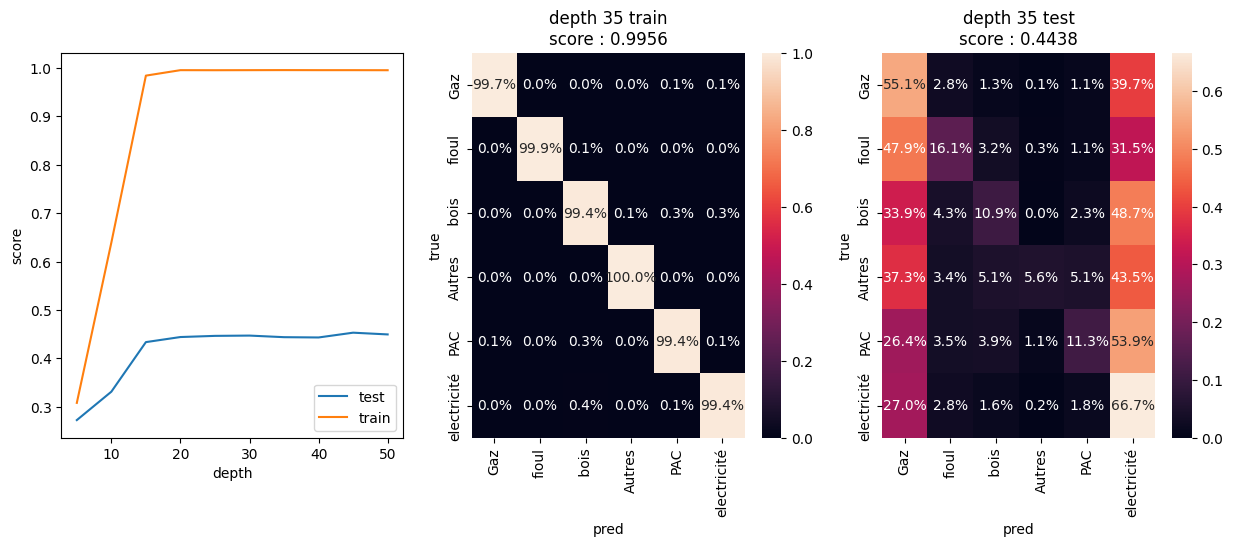

In [29]:


labels = ["Gaz", "fioul", " bois", "Autres", "PAC", "electricité"]

f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(scores.keys(), [dico['test'] for dico in scores.values()])
ax[0].plot(scores.keys(), [dico['train'] for dico in scores.values()])
ax[0].set_xlabel('depth')
ax[0].set_ylabel('score')
ax[0].legend(['test', 'train'])

y_pred_train = scores[35]['model'].predict(X_train)
y_pred_test = scores[35]['model'].predict(X_test)

show_matrix(y_pred_train, y_train, ax[1], f"depth 35 train", labels)
show_matrix(y_pred_test, y_test, ax[2], f"depth 35 test", labels)

In [35]:
# global parameters
col_X_hot = [["occupation", "nb_persons_home", "income", "department_number"], []]
col_y = ["heating_production"]
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y + ['index']]
    for i in range(len(col_X_hot))
]

#prepare each datasets
X, y, _ = prepare_dataset(
    training_prod.drop('index'), dictionary, col_X_hot[1], col_X_not_hot[1], col_y, False, True
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

hyperparams_models = [
    {
        "learning_rate": [0.001, 0.005, 0.01, 0.03, 0.07, 0.1, 0.3, 0.5],
        "n_estimators": [100],
    }
]
models = {
    "XGBClassifier": XGBClassifier,
}

# iterating over hyperparams
scores = {}
for hyperparams, (model_name, model) in zip(hyperparams_models, models.items()):
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(cut_param) - 1 for cut_param in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)
    print(all_poss)

    parametrized_model = model(**current_params)

    # register score
    parametrized_model.fit(X_train, y_train)
    train_score = f1_score(y_train, parametrized_model.predict(X_train), average="micro")
    test_score = f1_score(y_test, parametrized_model.predict(X_test), average="micro")
    scores[current_params['learning_rate']] = {'test' : deepcopy(test_score), 'train':deepcopy(train_score), 'model': deepcopy(parametrized_model)}
    i = 0
    nb_print = (all_poss // 4) + 1
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        parametrized_model = model(**current_params)
        # register score
        parametrized_model.fit(X_train, y_train)
        train_score = f1_score(y_train, parametrized_model.predict(X_train), average="micro")
        test_score = f1_score(y_test, parametrized_model.predict(X_test), average="micro")
        scores[current_params['learning_rate']] = {'test' : deepcopy(test_score), 'train': deepcopy(train_score), 'model': deepcopy(parametrized_model)}


8
0 [1, 0]
3 [4, 0]
6 [7, 0]


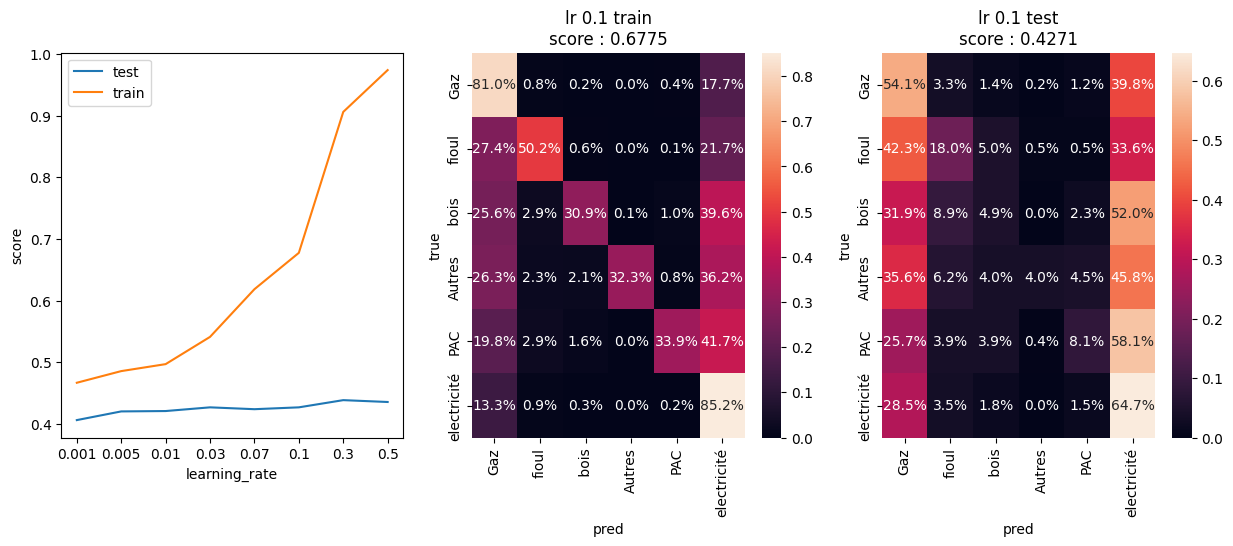

In [38]:
labels = ["Gaz", "fioul", " bois", "Autres", "PAC", "electricité"]

f, ax = plt.subplots(1, 3, figsize=(15, 5))

x_axis = [i for i in range(len(scores.keys()))]
x_ticks = scores.keys()

ax[0].plot(x_axis, [dico['test'] for dico in scores.values()])
ax[0].plot(x_axis, [dico['train'] for dico in scores.values()])
ax[0].set_xlabel('learning_rate')
ax[0].set_ylabel('score')
ax[0].set_xticks(x_axis, labels = x_ticks)
ax[0].legend(['test', 'train'])

y_pred_train = scores[0.1]['model'].predict(X_train)
y_pred_test = scores[0.1]['model'].predict(X_test)

show_matrix(y_pred_train, y_train, ax[1], f"lr 0.1 train", labels)
show_matrix(y_pred_test, y_test, ax[2], f"lr 0.1 test", labels)